In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
def get_good_slices(arr, s_indx=0):
    slices = []
    for i in range(s_indx, len(arr)):
        if arr[i].max() >= 1:
            slices.append(i)
            # classes = set(arr[i].flatten().tolist())
            # if len(classes) > 2:
            #     print('Found slice with more than 2 classes', i)
            #     print(classes)
    return slices

In [ ]:
import pickle
path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/lits_train_seg_files_tumor_slices.pickle'
with open(path, 'rb') as handle:
            loaded_dict = pickle.load(handle)

print(loaded_dict.keys())
        

In [1]:
# Save all paths with good slices
import os
from os import walk
import SimpleITK as sitk

'''
input: path to folder with ct slices and their segmentations
output: dict with key as path to ct and value as list of good slices
'''
def get_good_slices_from_path(img_folder):
    # get list of all files in folder
    f = next(walk(img_folder), (None, None, []))[2]
    # take only files with 'segmentation' in them
    filenames = [os.path.join(img_folder, filename) for filename in f if 'segmentation' in filename]

    good_seg_paths = {} # dict key is path and value is list of good slices
    good_vol_paths = {}
    for i, item in enumerate(filenames):
        f = item
        # check if f has '.nii' in it
        if '.nii' not in f:
            continue
        img = sitk.ReadImage(f, sitk.sitkUInt8)
        img = sitk.GetArrayFromImage(img)
        slices = get_good_slices(img)
        if len(slices) > 0:
            good_seg_paths[f] = slices
            vol_path = f.replace('segmentation', 'volume')
            good_vol_paths[vol_path] = slices
        # replace string 'segmnetation' with 'volume'
        
    return good_seg_paths, good_vol_paths

In [4]:
# save to pickle
import pickle 
def save_to_pickle(object, path):
    with open(path, 'wb') as handle:
        pickle.dump(object, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# load from pickle
import pickle
def load_from_pickle(path):
    with open(path, 'rb') as handle:
        loaded_dict = pickle.load(handle)
    return loaded_dict

seg_slices = load_from_pickle('/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/imagesFinetune/spleen_12_seg_dict.pkl')
vol_slices = load_from_pickle("/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/imagesFinetune/spleen_12_vol_dict.pkl")

In [6]:
seg_slices
vol_slices

{'/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/imagesTr/spleen_12.nii.gz': [100]}

## Test Segmentation

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
import numpy as np
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers2.diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline
from utils.utils import replace_unet_in_pipeline

PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/lits/no_text/one_shot_spleen_run2'
PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/lits/no_text/mse_seg_pred__prev_noisy_segmapt_latent_new_clip_run2'
UNET_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'unet_seg_weights.pt')
LORA_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'lora_weight_e1_s18500.pt')
LORA_TEXT_WEIGHTS_PATH = os.path.join(PATH_PREFIX,'lora_weight.text_encoder.pt')

model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')
# load clip weights
pipe.text_encoder.load_state_dict(
    torch.load('/disk4/Lev/Projects/diffusion_finetuning/training_scripts/clip_text_encoder_weights.pt'))
monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
# monkeypatch_lora(pipe.text_encoder, torch.load(LORA_TEXT_WEIGHTS_PATH), target_replace_module=["CLIPAttention"])

tune_lora_scale(pipe.unet, 1)
# tune_lora_scale(pipe.text_encoder, 1.5)

replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)



/opt/miniconda3/envs/lev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-26 18:06:32.754013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 18:06:34.176015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-26 18:06:34.176056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries.

#good slices:248


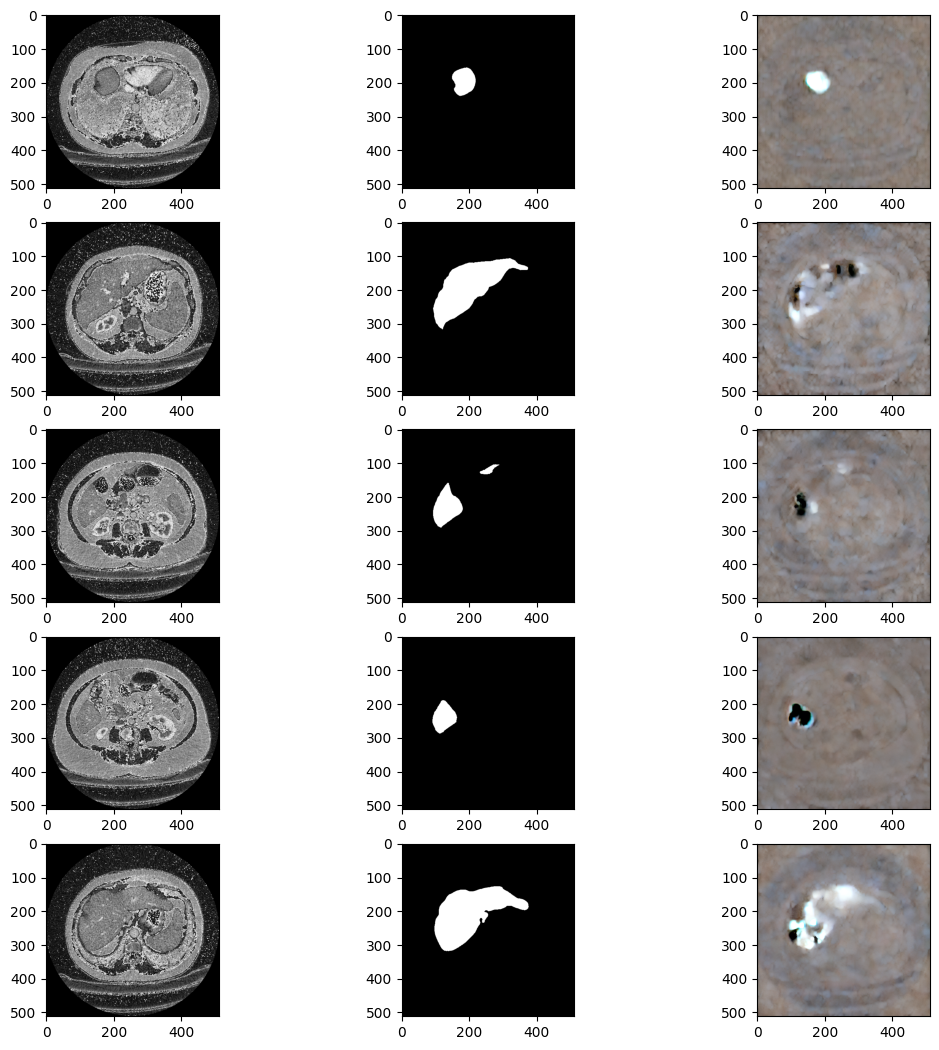

In [4]:
from utils.utils import diffuse_random_medical_images
n = 107 # patient number
PATH = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/test/'
# lits
lits_seg_path = os.path.join(PATH,f'segmentation-{n}.nii')
lits_path = os.path.join(PATH,f'volume-{n}.nii')

n = 12
PATH = '/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/'
msd_seg_path = os.path.join(PATH,f'labelsTr/spleen_{n}.nii.gz')
msd_path = os.path.join(PATH, f'imagesTr/spleen_{n}.nii.gz')

prompt = 'segmentation map of liver'
diffuse_random_medical_images(lits_path, lits_seg_path, pipe, prompt, 0.1, 12)

### Liver Segmentation Results

In [15]:
# reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Pipe loading
from utils.utils import load_pipe_from_path
pipe = load_pipe_from_path('/disk4/Lev/Projects/diffusion_finetuning/output/lits/no_text/mse_seg_pred__prev_noisy_segmapt_latent_new_clip_run2')
pipe.to('cuda:3')

In [ ]:
from training_scripts.segmentation_metrics import test_medical_segmentation_metrics
from utils.utils import load_pipe_from_path

prompt = 'segmentation map of liver'
lits_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/test'

lits_scores = test_medical_segmentation_metrics(lits_path, lits_path, pipe, prompt, 0.05, 12,
                                  n_examples_per_ct=100,
                                  max_examples=float('inf'),
                                  print_every=100)
n_examples = len(lits_scores['dice:'])
print(f'mdice: {np.mean(lits_scores["dice:"])} \
      miou: {np.mean(lits_scores["iou"])} \
      map_mask: {np.mean(lits_scores["ap_mask"])} total:{n_examples}')

### Zero Shot Spleen Results

In [ ]:
prompt = 'segmentation map of spleen'

ds_path = '/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/'
seg_path = os.path.join(ds_path,'labelsTr')
vol_path = os.path.join(ds_path, 'imagesTr')

zero_spleen_scores = test_medical_segmentation_metrics(seg_path, vol_path, pipe, prompt, 0.05, 12,
                                  n_examples_per_ct=float('inf'),
                                  max_examples=float('inf'),
                                  print_every=100)

n_examples = len(zero_spleen_scores['dice:'])
print(f'mdice: {np.mean(zero_spleen_scores["dice:"])} \
      miou: {np.mean(zero_spleen_scores["iou"])} \
      map_mask: {np.mean(zero_spleen_scores["ap_mask"])} total:{n_examples}')

### Zero shot Lung Results

In [ ]:
prompt = 'segmentation map of lung'

ds_path = '/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task06_Lung'
seg_path = os.path.join(ds_path,'labelsTr')
vol_path = os.path.join(ds_path, 'imagesTr')

zero_lung_scores = test_medical_segmentation_metrics(seg_path, vol_path, pipe, prompt, 0.05, 12,
                                  n_examples_per_ct=float('inf'),
                                  max_examples=float('inf'),
                                  print_every=100)

n_examples = len(zero_lung_scores['dice:'])
print(f'mdice: {np.mean(zero_lung_scores["dice:"])} \
      miou: {np.mean(zero_lung_scores["iou"])} \
      map_mask: {np.mean(zero_lung_scores["ap_mask"])} total:{n_examples}')

### Zero Shot Heart Results

In [ ]:
prompt = 'segmentation map of heart'

ds_path = '/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task02_Heart'
seg_path = os.path.join(ds_path,'labelsTr')
vol_path = os.path.join(ds_path, 'imagesTr')

zero_heart_scores = test_medical_segmentation_metrics(seg_path, vol_path, pipe, prompt, 0.05, 12,
                                  n_examples_per_ct=float('inf'),
                                  max_examples=float('inf'),
                                  print_every=100)

n_examples = len(zero_heart_scores['dice:'])
print(f'mdice: {np.mean(zero_heart_scores["dice:"])} \
      miou: {np.mean(zero_heart_scores["iou"])} \
      map_mask: {np.mean(zero_heart_scores["ap_mask"])} total:{n_examples}')

### One shot Spleen Results

dice:0.5518202689406363 iou:0.3810440493715321 precision:0.5115536637275768 recall:0.5989676041295835
global_step: 600,                         mdice: 0.4521537544239102,                         miou: 0.3258068786514588,                         mAPmask: 0.28479095805880966


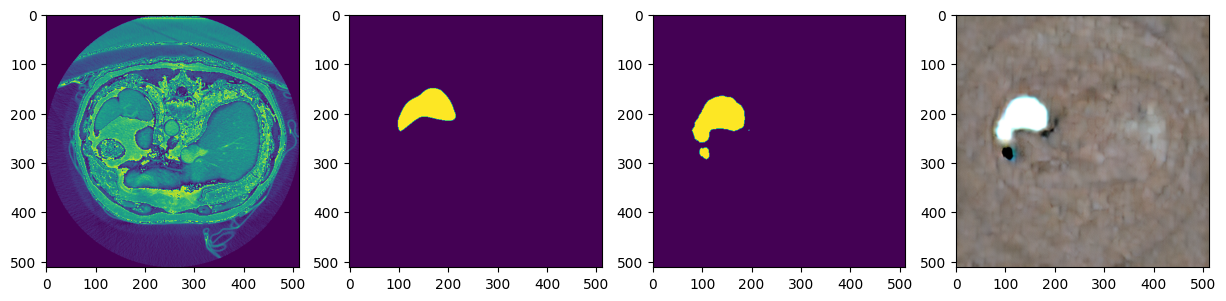

Patient:  56%|█████▌    | 23/41 [13:11<11:57, 39.86s/it]

dice:0.6185457578284934 iou:0.4477497255762898 precision:0.4517665300697752 recall:0.9805288461538462
global_step: 700,                         mdice: 0.46196120633943644,                         miou: 0.3347435360540676,                         mAPmask: 0.29681190931510193


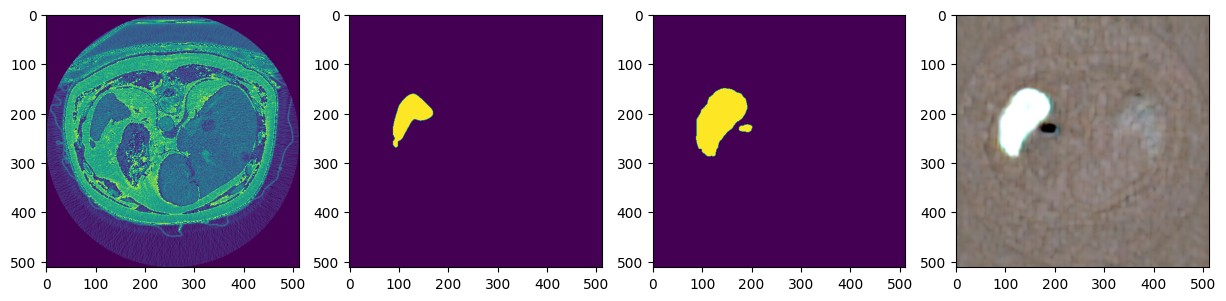

Patient:  66%|██████▌   | 27/41 [15:26<07:16, 31.16s/it]

In [9]:
from training_scripts.segmentation_metrics import test_medical_segmentation_metrics
from utils.utils import load_pipe_from_path
prompt = 'segmentation map of spleen'
ds_path = '/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/'
msd_seg_path = os.path.join(ds_path,'labelsTr')
msd_path = os.path.join(ds_path, 'imagesTr')

pipe = load_pipe_from_path('/disk4/Lev/Projects/diffusion_finetuning/output/lits/no_text/one_shot_spleen_run2',
                           load_clip_weights=True,)
pipe.to('cuda:3')

spleen_scores = test_medical_segmentation_metrics(msd_seg_path, msd_path, pipe, prompt, 0.1, 12,
                                  n_examples_per_ct=float('inf'),
                                  max_examples=float('inf'),
                                  print_every=100)

### One shot Lung Results

In [ ]:
prompt = 'segmentation map of lung'

ds_path = '/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task06_Lung'
seg_path = os.path.join(ds_path,'labelsTr')
vol_path = os.path.join(ds_path, 'imagesTr')

pipe = load_pipe_from_path('',
                           load_clip_weights=True,)
pipe.to('cuda:3')

lung_scores = test_medical_segmentation_metrics(seg_path, vol_path, pipe, prompt, 0.05, 12,
                                  n_examples_per_ct=float('inf'),
                                  max_examples=float('inf'),
                                  print_every=100)

n_examples = len(lung_scores['dice:'])
print(f'mdice: {np.mean(lung_scores["dice:"])} \
      miou: {np.mean(lung_scores["iou"])} \
      map_mask: {np.mean(lung_scores["ap_mask"])} total:{n_examples}')

### One Shot Heart Results

In [ ]:
prompt = 'segmentation map of heart'

ds_path = '/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task02_Heart'
seg_path = os.path.join(ds_path,'labelsTr')
vol_path = os.path.join(ds_path, 'imagesTr')

pipe = load_pipe_from_path(,
                           load_clip_weights=True,)
pipe.to('cuda:3')

zero_lung_scores = test_medical_segmentation_metrics(seg_path, vol_path, pipe, prompt, 0.05, 12,
                                  n_examples_per_ct=float('inf'),
                                  max_examples=float('inf'),
                                  print_every=100)

n_examples = len(zero_lung_scores['dice:'])
print(f'mdice: {np.mean(zero_lung_scores["dice:"])} \
      miou: {np.mean(zero_lung_scores["iou"])} \
      map_mask: {np.mean(zero_lung_scores["ap_mask"])} total:{n_examples}')

In [41]:
n_examples = len(scores['dice:'])
print(f'mdice: {np.mean(scores["dice:"])} \
      miou: {np.mean(scores["iou"])} \
      map_mask: {np.mean(scores["ap_mask"])} total:{n_examples}')

mdice: 0.4074637574579439       miou: 0.273413379184826       map_mask: 0.0010091172345073876 total:205


In [52]:
from training_scripts.segmentation_metrics import dice_coeff, iou_score,convert_seg_array_to_binary_rgb, convert_RGB_to_seg_mask, compute_mdice_miou_for_model_outputs

def test_mdice_miou(seg_path, vol_path, pipe, n_examples_per_ct=5):
    # get list of all files in folder
    if seg_path == vol_path:
        f = next(walk(path), (None, None, []))[2]
        # take only files with 'segmentation' in them
        seg_filenames = [os.path.join(path, filename) for filename in f if 'segmentation' in filename]
        # take only files with 'volume' in them
        vol_filenames = [os.path.join(path, filename) for filename in f if 'volume' in filename]
    else:
        f_seg = next(walk(seg_path), (None, None, []))[2]
        f_vol = next(walk(vol_path), (None, None, []))[2]
        seg_filenames = [os.path.join(seg_path, filename) for filename in f_seg]
        vol_filenames = [os.path.join(vol_path, filename) for filename in f_vol]
        
    mdice = []
    miou = []
    for i, item in enumerate(zip(seg_filenames, vol_filenames)):
        f_seg, f_vol = item
        # check if f has '.nii' in it
        if '.nii' not in f_seg or '.nii' not in f_vol:
            continue
        
        seg_img = sitk.ReadImage(f_seg, sitk.sitkUInt8)
        seg_arr = sitk.GetArrayFromImage(seg_img)
        img = sitk.ReadImage(f_vol, sitk.sitkUInt8)
        img_arr = sitk.GetArrayFromImage(img)
          
        slices = get_good_slices(seg_arr)
        indices = random.sample(slices, min(n_examples_per_ct, len(slices)))
                        
        for i in indices:
            ct_slice = img_arr[i]
            seg_slice = (seg_arr[i] * 256).clip(0, 255) # make all values be 0 or 255

            in_img = Image.fromarray(ct_slice).convert('RGB')
            output = pipe('segmentation map of liver', in_img, strength=0.05, guidance_scale=12, modified_unet=True, segmentation=True).images[0]
            output = convert_seg_array_to_binary_rgb(output)           
            output = convert_RGB_to_seg_mask(output)
            
            dice = dice_coeff(output, seg_slice)
            iou = iou_score(output, seg_slice)
            print(f'dice:{dice} iou:{iou}')
            mdice.append(dice)
            miou.append(iou)
            
    return np.mean(mdice), np.mean(miou), len(mdice)

In [1]:
mdice, miou, n_examples = test_mdice_miou(PATH, pipe, 1e3)


hello


In [79]:
print(f'mdice:{mdice}, miou:{miou}, nexamples{n_examples}')
seg_params_dict={'mdice':mdice, 'miou':miou, 'n_examples':n_examples}

import pickle
with open('seg_params_dict.pkl', 'wb') as f:
    pickle.dump(seg_params_dict, f)

mdice:0.7844272882775177, miou:0.6996854969856797, nexamples4434


In [ ]:
mdice, miou, n_examples = test_mdice_miou(PATH, pipe, 1e3)
print(f'mdice:{mdice} miou:{miou}')

In [ ]:
from training_scripts.segmentation_metrics import dice_coeff, iou_score,convert_seg_array_to_binary_rgb, convert_RGB_to_seg_mask, compute_mdice_miou_for_model_outputs
example_n = 4
seg = seg_preds[example_n]
seg_arr = np.array(seg)

# get unique rgb values from seg_arr
unique, count = np.unique(seg_arr.reshape(-1,3), axis=0, return_counts=True)
sorted_indices = np.argsort(count)[::-1]
unique_sorted = unique[sorted_indices]
count_sorted  = count[sorted_indices]

for i, (color, count) in enumerate(zip(unique_sorted, count_sorted)):
    print(color,':', count)

# plot example images side by side
seg_arr = convert_seg_array_to_binary_rgb(seg)
seg_pred_img = Image.fromarray(seg_arr)
seg_gt = (seg_imgs[example_n] * 256).clip(0,255)
real_seg_img = Image.fromarray(seg_gt).convert('RGB')
plot_2_imgs_side_by_side(seg_pred_img, real_seg_img)


# compute dice and iou scores
seg_pred = convert_RGB_to_seg_mask(seg_arr)

print(seg_gt.shape, ' ', seg_pred.shape)
dice = dice_coeff(seg_pred, seg_gt)
iou = iou_score(seg_pred, seg_gt)

print(f'dice:{dice} IoU:{iou}')


In [64]:
mdice, miou = compute_mdice_miou_for_model_outputs(seg_preds, seg_imgs)
print(f'mdice:{mdice} miou:{miou}')

mdice:0.9147699775644998 miou:0.843587353516966


In [11]:
def plot_2_imgs_side_by_side(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(13,13))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    plt.show()

In [151]:
# function to computs the most different pixels based on euclidean distance
# pixels is a np array of shape (N, 3) where N is the number of 
# returns the 3 pixels with the largest euclidean distance from each other
def get_most_different_pixels(pixels):
    # compute the euclidean distance between all pixels
    dist = np.linalg.norm(pixels[:, None] - pixels, axis=-1)
    # get the 3 pixels with the largest distance from each other
    max_dist = np.max(dist, axis=0)
    max_dist = np.argsort(max_dist)[-3:]
    return pixels[max_dist]

In [160]:
# function that replaces all pixels in array based on how close they are to the 3 inputs pixel values
# array is a np array of shape (H, W, 3)
# for each pixel in img_arr change in to (0,0,0) if its closest to the first pixel in seg_pixels
def convert_to_segmap(img_arr, seg_pixels):
    # Compute the Euclidean distance between each pixel and each input pixel
    distances = np.sqrt(np.sum((img_arr[..., np.newaxis, :] - seg_pixels[np.newaxis, np.newaxis, :, :])**2, axis=-1))

    # Find the indices of the closest input pixel for each pixel
    closest_indices = np.argmin(distances, axis=-1)

    # Create an array to store the result
    result = np.zeros_like(img_arr)

    # Replace each pixel with the corresponding color based on the closest input pixel
    result[closest_indices == 0] = [0, 0, 0]
    result[closest_indices == 1] = [128, 128, 128]
    result[closest_indices == 2] = [255, 255, 255]

    return result

[[159 148 131]
 [159 147 126]
 [202 200 185]]


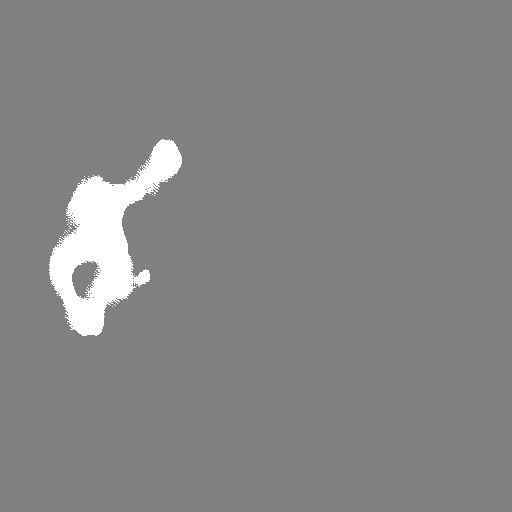

In [162]:
output_arr = np.array(output)
unique_pixels, counts = np.unique(output_arr.reshape(-1,3), axis=0, return_counts=True)
# for pixel, count in zip(unique_pixels, counts):
    # print(pixel, count)

# get two most common pixels
most_common = unique_pixels[np.argsort(counts)[-20:]]
represetive_pixels = get_most_different_pixels(unique_pixels)
print(represetive_pixels)
represetive_pixels = np.array([[0, 0, 0], [128, 128, 128], [255, 255, 255]])
segmap = convert_to_segmap(output_arr, represetive_pixels)
segmap_img = Image.fromarray(segmap)
segmap_img

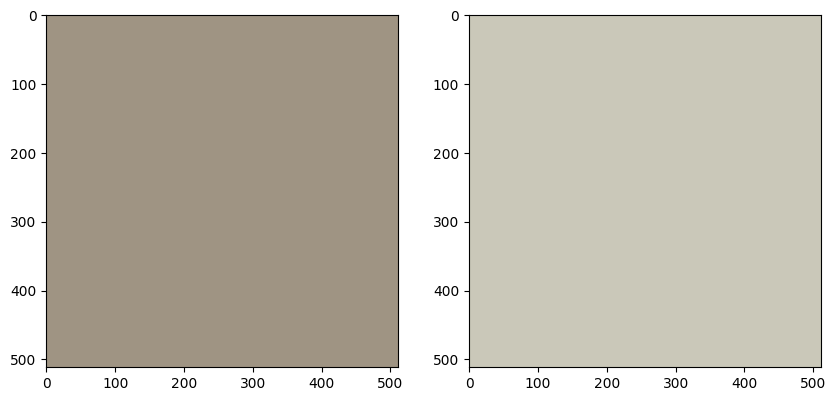

In [155]:
# create image with color (134, 118, 100)
img1 = Image.new('RGB', (512, 512), color = (159, 148, 131))
img2 = Image.new('RGB', (512, 512), color = (202, 200, 185))

# plot img1 and img2 side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [21]:
path = os.path.join(PATH,f'volume-{n}.nii')

img = sitk.ReadImage(path, sitk.sitkUInt8)
img_arr = sitk.GetArrayFromImage(img)[337].astype(np.uint16)


In [ ]:
seg_img = Image.fromarray(img_arr).convert('RGB')

seg_arr = np.array(seg_img)
print(seg_arr.shape)
print(set(seg_arr.flatten().tolist()))
seg_arr = seg_arr.reshape(-1,3)
unique_pixels = np.unique(seg_arr, axis=0, return_counts=False)
print(unique_pixels)

In [ ]:
import os
import fnmatch
import pickle

def list_files(directory, substring):
    files = []
    for root, dir, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, substring + '*'):
            files.append(os.path.join(root, filename))
    return files

seg_files = list_files(PATH, 'segmentation')
# print(len(seg_files), '\n', len(vol_files))

seg_files_w_good_slices = {}
for path in seg_files:
    img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(img)
    good_slices = get_good_slices(img_arr)
    seg_files_w_good_slices[path] = good_slices

In [ ]:
seg_files_w_good_slices

### Test LITS17 DS

In [6]:
ct_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/volume-102.nii'
seg_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/segmentation-102.nii'

ct = sitk.ReadImage(ct_path, sitk.sitkUInt8)
seg = sitk.ReadImage(seg_path, sitk.sitkUInt8)

ct_array = sitk.GetArrayFromImage(ct)
seg_array = sitk.GetArrayFromImage(seg)

In [37]:
seg_img = Image.fromarray(seg_array*127)
ct_img = Image.fromarray(ct_array)

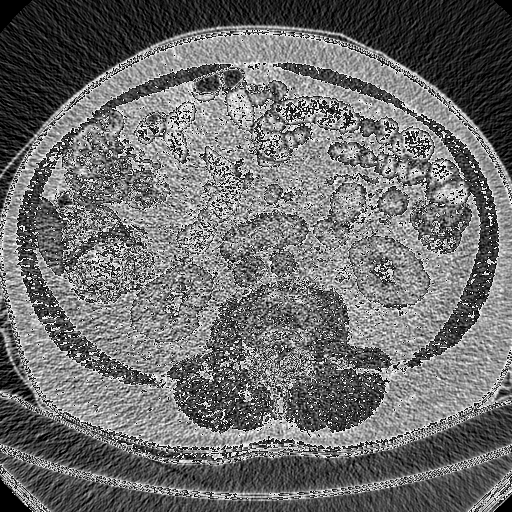

In [38]:
ct_img

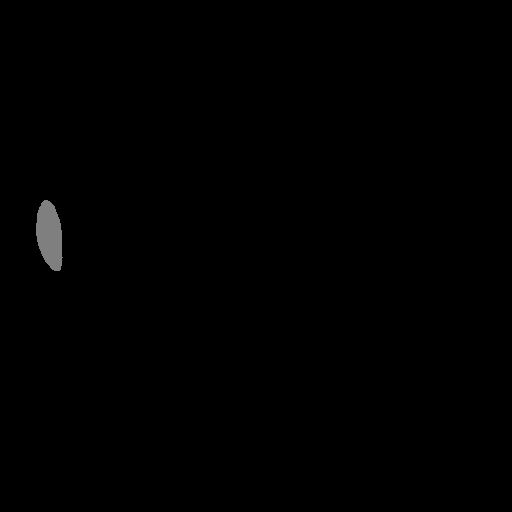

In [36]:
seg_img

In [ ]:
good_slices = get_good_slices(seg_array)
good_slices

In [56]:
def convert_tensor_to_img(tensor, normalized=False):
    if normalized:
        arr = np.array(tensor*255, dtype=np.uint8)
    else:
        arr = np.array(tensor, dtype=np.uint8)
    print(arr.shape)
    arr = np.moveaxis(arr, [0, 1, 2], [2, 0, 1])
    print(arr.shape)
    if arr.shape[2] == 1:
        arr = arr.squeeze(2)
    img = Image.fromarray(arr)
    return img 